In [1]:
import re
import json
import nltk
import string
import random
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Preprocessing Teks**

In [4]:
replace = [
    ['ibu', ['ibuku', 'mami', 'mama']],
    ['ayah', ['ayahku', 'papa', 'daddy']],
    ['saudara', ['adikku', 'adek', 'kakakku', 'koko', 'cece']],
    ['teman', ['temanku']],
    ['meninggal', ['mati']]
]

In [5]:
def preprocess_text(kalimat):
  filtered = re.sub(r'[^\w\d\s]', '', kalimat.lower())
  words = word_tokenize(filtered)

  clean_word = []
  for word in words:
    replaced = False
    for replacement, target in replace:
      if word in target:
        clean_word.append(replacement)
        replaced = True
    if not replaced:
      clean_word.append(word)

  return ' '.join(clean_word)


# **Reading Train & Val Dataset**

In [6]:
with open('/content/Mental Health Conversational.json', 'r') as content:
  chatbot = json.load(content)
data = pd.DataFrame(chatbot['intents'])

In [7]:
dictionary = {"tag":[], "patterns":[], "responses":[]}
for i in range (len(data)):
  pattern = data[data.index==i]['patterns'].values[0]
  response = data[data.index==i]['responses'].values[0]
  tag = data[data.index==i]['tag'].values[0]
  for j in range (len(pattern)):
    dictionary['tag'].append(tag)
    dictionary['patterns'].append(preprocess_text(pattern[j]))
    dictionary['responses'].append(response)
data = pd.DataFrame.from_dict(dictionary)
data

,tag,patterns,responses
0,greeting,hai,[Halo! Selamat bertemu denganmu. Bagaimana kab...
1,greeting,halo,[Halo! Selamat bertemu denganmu. Bagaimana kab...
2,greeting,hai apa kabar,[Halo! Selamat bertemu denganmu. Bagaimana kab...
3,greeting,hi,[Halo! Selamat bertemu denganmu. Bagaimana kab...
4,greeting,assalamualaikum,[Halo! Selamat bertemu denganmu. Bagaimana kab...
...,...,...,...
212,fact_28,bagaimana saya bisa menjaga hubungan sosial ba...,"[Banyak orang yang sendirian saat ini, tapi ki..."
213,fact_29,apa perbedaan antara kecemasan dan stress,[Stres dan kecemasan sering digunakan secara b...
214,fact_29,perbedaan kecemasan dan stress,[Stres dan kecemasan sering digunakan secara b...
215,fact_30,apa perbedaan antara kesedihan dan depresi,[Kesedihan merupakan reaksi normal terhadap ke...


In [8]:
with open('/content/Validation_Conversation.json', 'r') as content:
  val_chatbot = json.load(content)
val_data = pd.DataFrame(val_chatbot['intents'])


In [9]:
dictionary = {"tag":[], "patterns":[]}
for i in range (len(val_data)):
  pattern = val_data[val_data.index==i]['patterns'].values[0]
  tag = val_data[val_data.index==i]['tag'].values[0]
  for j in range (len(pattern)):
    dictionary['tag'].append(tag)
    dictionary['patterns'].append(preprocess_text(pattern[j]))
val_data = pd.DataFrame.from_dict(dictionary)
val_data

,tag,patterns
0,greeting,halo
1,greeting,hai apa kabar
2,greeting,hi
3,morning,pagi
4,afternoon,siang
...,...,...
111,fact_26,apa yang harus saya lakukan jika saya khawatir...
112,fact_27,bagaimana saya tahu kalau saya tidak sehat
113,fact_28,bagaimana saya bisa menjaga hubungan sosial ba...
114,fact_29,perbedaan kecemasan dan stress


In [10]:
# Training
data['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'about', 'skill', 'creation', 'help', 'sad', 'stressed',
       'worthless', 'depressed', 'happy', 'casual', 'anxious',
       'not-talking', 'sleep', 'scared', 'death', 'understand', 'done',
       'suicide', 'hate-you', 'hate-me', 'default', 'jokes', 'repeat',
       'wrong', 'stupid', 'location', 'something-else', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user_meditation', 'hugu_useful', 'user-advice',
       'learn_mental_health', 'mental_health_fact', 'fact_1', 'fact_2',
       'fact_3', 'fact_4', 'fact_5', 'fact_6', 'fact_7', 'fact_8',
       'fact_9', 'fact_10', 'fact_11', 'fact_12', 'fact_13', 'fact_14',
       'fact_15', 'fact_16', 'fact_17', 'fact_18', 'fact_19', 'fact_20',
       'fact_21', 'fact_22', 'fact_23', 'fact_24', 'fact_25', 'fact_26',
       'fact_27', 'fact_28', 'fact_29', 'fact_30'], dtype=object)

In [11]:
# Validation
val_data['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'about', 'skill', 'creation', 'help', 'sad', 'stressed',
       'worthless', 'depressed', 'happy', 'casual', 'anxious',
       'not-talking', 'sleep', 'scared', 'death', 'understand', 'done',
       'suicide', 'hate-you', 'hate-me', 'default', 'jokes', 'repeat',
       'wrong', 'stupid', 'location', 'something-else', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user_meditation', 'hugu_useful', 'user-advice',
       'learn_mental_health', 'mental_health_fact', 'fact_1', 'fact_2',
       'fact_3', 'fact_4', 'fact_5', 'fact_6', 'fact_7', 'fact_8',
       'fact_9', 'fact_10', 'fact_11', 'fact_12', 'fact_13', 'fact_14',
       'fact_15', 'fact_16', 'fact_17', 'fact_18', 'fact_19', 'fact_20',
       'fact_21', 'fact_22', 'fact_23', 'fact_24', 'fact_25', 'fact_26',
       'fact_27', 'fact_28', 'fact_29', 'fact_30'], dtype=object)

# **Tokenizing Train and Validation Pattern & Tag**

**Adding Word Dictionary**

In [12]:
with open('/content/word_dict.json', 'r') as f:
  json_dict = json.load(f)
tokenizer_json=json_dict.keys()

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(tokenizer_json)

word_index = tokenizer.word_index
print(len(word_index))

18727


Shuffling dataset for better training (*hopefully*)

In [13]:
data = shuffle(data)
val_data = shuffle(val_data)

In [16]:
label_encode = LabelEncoder()

tokenizer.fit_on_texts(data['patterns'])
tokenizer.fit_on_texts(val_data['patterns'])

# Training Set
pattern_train = tokenizer.texts_to_sequences(data['patterns'])
x_train = pad_sequences(pattern_train, padding='post', maxlen=12, truncating='pre')
print("Training Input Shape : ", x_train.shape)
print(len(x_train[0]))

x_label = label_encode.fit_transform(data['tag'])
print("Training Label Shape : ", x_label.shape)
print("Num of classes: ", len(np.unique(x_label)))

Training Input Shape :  (217, 12)
12
Training Label Shape :  (217,)
Num of classes:  75


In [17]:
# Validation Set
pattern_val = tokenizer.texts_to_sequences(val_data['patterns'])
y_train = pad_sequences(pattern_val, padding='post', maxlen=12, truncating='pre')
print("Validation Input Shape : ", y_train.shape)
print(len(y_train[0]))

y_label = label_encode.fit_transform(val_data['tag'])
print("Validation Label Shape : ",y_label.shape)
print("Num of classes: ", len(np.unique(y_label)))

Validation Input Shape :  (116, 12)
12
Validation Label Shape :  (116,)
Num of classes:  75


In [18]:
vocabulary = len(tokenizer.word_index)
print("Number unique word : ",vocabulary)
print("Output Length : ", label_encode.classes_.shape[0])


Number unique word :  18764
Output Length :  75


Converting known word/patterns from dictionary, train and validation dataset

In [19]:
word_dictionary = {item[0]: item[1] for item in tokenizer.word_index.items()}
with open('tokenizer_chatbot_dict.json', 'w') as json_file:
  json.dump(word_dictionary, json_file, indent=4)

Converting tag into json

In [20]:
leDecode = LabelEncoder()
leDecode.fit(val_data['tag'])
name_mapping = dict(zip(leDecode.classes_, leDecode.transform(leDecode.classes_)))
transformed = leDecode.transform(leDecode.classes_).tolist()
name_mapping = dict(zip(leDecode.classes_, transformed))
with open('label_decoder.json', 'w') as json_file:
  json.dump(name_mapping, json_file, indent=4)

# **Embedding** **Glove**

In [ ]:
# !rm -f glove.6B.zip
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-12-16 06:05:02--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-16 06:05:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove.6B.zip.2        4%[                    ]  38.37M  8.60MB/s    eta 70s    ^C
Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
glove_dir = "/content/glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding='utf8')
for line in file_:
  arr = line.split()
  single_word = arr[0]
  w = np.asarray(arr[1:],dtype='float32')
  embeddings_index[single_word] = w
file_.close()
print(len(embeddings_index))

400000


In [ ]:
max = vocabulary + 1
word_index =tokenizer.word_index
embedding_mat = np.zeros((max, 100)).astype(object)
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_mat[i] = embedding_vector

# **Model Architecture, Chatbot Test, Plotting and Training Model**

In [ ]:
def chatbot_test():
  while True:
    user_input = input("User: ").lower()
    pattern_test=preprocess_text(user_input)
    pattern_test = tokenizer.texts_to_sequences([pattern_test])
    x_test = pad_sequences(pattern_test, x_train.shape[1])

    prediction = model.predict(x_test)[0]
    label = label_encode.inverse_transform([np.argmax(prediction)])[0]
    response = data[data['tag'] == label]['responses'].values[0]
    print("Label:",label)
    print("Chatbot: ", format(random.choice(response)))
    if label=='goodbye' or label=='thanks':
      break

In [ ]:
def plot_training_history(history):
    # Plotting training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.ylim(0, 1.0)

    # Plotting training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='orange')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='yellow')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.ylim(0, 4.0)

    # Display the plots
    plt.show()


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_length=x_train.shape[1], input_dim=vocabulary+1, output_dim = 100, mask_zero=True,
                              weights=[embedding_mat], trainable=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.2),

    # tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(len(np.unique(x_label)), activation='softmax')
])

model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 100)           1876500   
                                                                 
 dropout_4 (Dropout)         (None, 12, 100)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 12, 256)           176640    
 onal)                                                           
                                                                 
 layer_normalization_4 (Lay  (None, 12, 256)           512       
 erNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 12, 256)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)              

In [ ]:
# Callback function to stop training when the accuracy is above 90%
# and validation accuracy above 90%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.8:
            self.model.stop_training = True

In [ ]:
history = model.fit(x_train, x_label, validation_data=(y_train, y_label),
                    batch_size=32, epochs=1000, callbacks=[MyCallback()])

Epoch 1/1000
7/7 [==============================] - 26s 1s/step - loss: 4.7771 - accuracy: 0.0230 - val_loss: 3.6952 - val_accuracy: 0.1983
Epoch 2/1000
7/7 [==============================] - 1s 99ms/step - loss: 3.8061 - accuracy: 0.1014 - val_loss: 3.0550 - val_accuracy: 0.3276
Epoch 3/1000
7/7 [==============================] - 1s 103ms/step - loss: 3.2457 - accuracy: 0.2120 - val_loss: 2.5382 - val_accuracy: 0.4569
Epoch 4/1000
7/7 [==============================] - 1s 103ms/step - loss: 2.9227 - accuracy: 0.2673 - val_loss: 2.1688 - val_accuracy: 0.4828
Epoch 5/1000
7/7 [==============================] - 1s 101ms/step - loss: 2.5997 - accuracy: 0.4055 - val_loss: 1.8819 - val_accuracy: 0.5517
Epoch 6/1000
7/7 [==============================] - 1s 93ms/step - loss: 2.4135 - accuracy: 0.4424 - val_loss: 1.6803 - val_accuracy: 0.5776
Epoch 7/1000
7/7 [==============================] - 1s 104ms/step - loss: 2.0624 - accuracy: 0.5300 - val_loss: 1.4925 - val_accuracy: 0.6552
Epoch 8/10

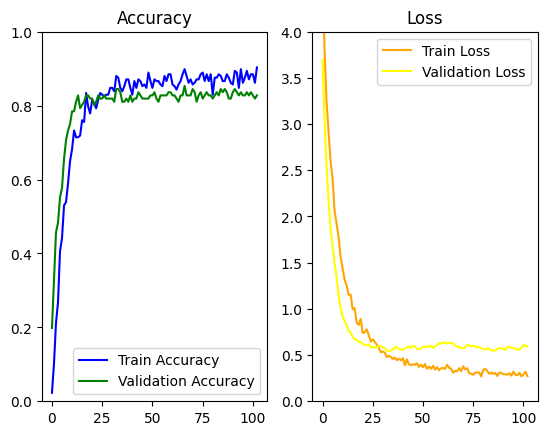

In [ ]:
plot_training_history(history)

# **Chatbot Testing**

In [ ]:
chatbot_test()

User: siapa kamu
1/1 [==============================] - 0s 25ms/step
Label: about
Chatbot:  Saya Pandora, Personal Therapeutic AI Assistant Anda. Bagaimana perasaan Anda hari ini
User: tolong saya
1/1 [==============================] - 0s 24ms/step
Label: fact_4
Chatbot:  Untuk diagnosis depresi, seseorang perlu mengalami suasana hati yang rendah atau kehilangan minat atau kesenangan dalam hidup setidaknya selama 2 minggu. Juga, mereka akan mengalami gejala-gejala berikut: perasaan sedih, putus asa, atau mudah tersinggung hampir setiap hari setiap hari.
User: tolong bantu
1/1 [==============================] - 0s 24ms/step
Label: help
Chatbot:  Ya, tentu. Ada yang bisa saya bantu?
User: aku merasa sedih
1/1 [==============================] - 0s 30ms/step
Label: help
Chatbot:  Ceritakan masalahmu agar saya bisa membantumu
User: aku sedih
1/1 [==============================] - 0s 44ms/step
Label: scared
Chatbot:  Semua akan baik-baik saja. Perasaan ini hanya sesaat.
User: aku merasa tert

# **Saving and Converting Model into TFLite**

In [ ]:
tf.saved_model.save(model,'/content/TFLite/')


In [ ]:
saved_model_path = '/content/TFLite/'


loaded_model = tf.saved_model.load(saved_model_path)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('chatbot_model.tflite')
tflite_model_file.write_bytes(tflite_model)

9897324

In [ ]:
from google.colab import files
files.download('chatbot_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>